In [1]:
# Get audio files

import os
import requests
import tarfile

url = "https://huggingface.co/datasets/MLCommons/peoples_speech/resolve/main/train/clean/clean_000000.tar"

download_folder = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(download_folder, exist_ok=True)
tar_path = os.path.join(download_folder, "clean_000000.tar")

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(tar_path, 'wb') as f:
        f.write(response.raw.read())
    print(f"Downloaded tar file to {tar_path}")
else:
    print(f"Failed to download file: {response.status_code}")

try:
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=download_folder)
    print(f"Extracted tar file to {download_folder}")
except tarfile.TarError as e:
    print(f"Error extracting tar file: {e}")

try:
    os.remove(tar_path)
    print(f"Removed tar file: {tar_path}")
except OSError as e:
    print(f"Error removing tar file: {e}")


Downloaded tar file to c:\CodeProjects\University\3.2_VU\deep learning\gmmGroup\data\clean_000000.tar
Extracted tar file to c:\CodeProjects\University\3.2_VU\deep learning\gmmGroup\data
Removed tar file: c:\CodeProjects\University\3.2_VU\deep learning\gmmGroup\data\clean_000000.tar


In [2]:
# Make dirs

import os
resultFolderName = "audioResults"
results = os.path.join(os.path.dirname(os.getcwd()), resultFolderName)
os.makedirs(results, exist_ok=True)

model1Name = "SpeechT5"
model1Dir = os.path.join(results, model1Name)
os.makedirs(model1Dir, exist_ok=True)

model2Name = "VitsModel"
model2Dir = os.path.join(results, model2Name)
os.makedirs(model2Dir, exist_ok=True)

In [3]:
# Load dataset information

from datasets import load_dataset

dataset = load_dataset("json", data_files="clean.json")

In [4]:
printfirstDataElement = False

if printfirstDataElement:
    print(dataset['train']['training_data'][0]['name'][0])
    print(dataset['train']['training_data'][0]['label'][0])

In [5]:
# Input arrays

textInput = [] 
audioPathInput = [] 

for data in dataset['train']['training_data']:
    textInput.extend(data['label'])
    audioPathInput.extend(data['name'])

printInputArrays = False

if printInputArrays:
    for i in range(len(textInput)):
        print(textInput[i])

    for i in range(len(audioPathInput)):
        print(audioPathInput[i])

In [11]:
# SpeechT5

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from scipy.io.wavfile import write
from datasets import load_dataset
import torch
import os
from tqdm import tqdm
import time

# Initialize processor and models
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

# Check if a GPU is available and move the model to GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
vocoder.to(device)

print(f"Using device: {device}")

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[i % len(embeddings_dataset)]["xvector"]).unsqueeze(0).to(device)

outputs_SpeechT5 = []

start_time = time.time()
for i in tqdm(range(len(textInput)), desc="Processing", unit="file"):
    text = textInput[i]
    inputs = processor(text=text, return_tensors="pt").to(device)
    
    with torch.no_grad():
        speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

    # output_path = os.path.join(model1Dir, f"{audioPathInput[i]}.wav")
    # output_waveform = speech.squeeze().cpu().numpy()
    # write(output_path, 16000, output_waveform)

    outputs_SpeechT5.append(speech)

end_time = time.time()

total_time = end_time - start_time
print(f"Total processing time: {total_time:.2f} seconds")


Using device: cuda


c:\Users\dauma\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for Matthijs/cmu-arctic-xvectors contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Matthijs/cmu-arctic-xvectors
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating validation split: 0 examples [00:00, ? examples/s]

Processing:   1%|          | 3/397 [01:04<2:20:11, 21.35s/file]


KeyboardInterrupt: 

In [24]:
# VitsModel generating speech audio

from transformers import VitsModel, AutoTokenizer
import torch
from scipy.io.wavfile import write
import os
from tqdm import tqdm
import time

model = VitsModel.from_pretrained("facebook/mms-tts-eng")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-eng")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f"Using device: {device}")

outputs_VitsModel = []

start_time = time.time()
for i in tqdm(range(len(textInput)), desc="Processing", unit="file"):
    text = textInput[i]
    inputs = tokenizer(text, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model(**inputs).waveform
    output_path = os.path.join(model2Dir, f"{audioPathInput[i]}.wav")
    output_waveform = output.squeeze().cpu().numpy()
    write(output_path, 16000, output_waveform)

    outputs_VitsModel.append(output)

end_time = time.time()

total_time = end_time - start_time
print(f"Total processing time: {total_time:.2f} seconds")

Some weights of the model checkpoint at facebook/mms-tts-eng were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.1.wei

cuda


Processing: 100%|██████████| 397/397 [01:55<00:00,  3.45file/s]

Total processing time: 115.00 seconds


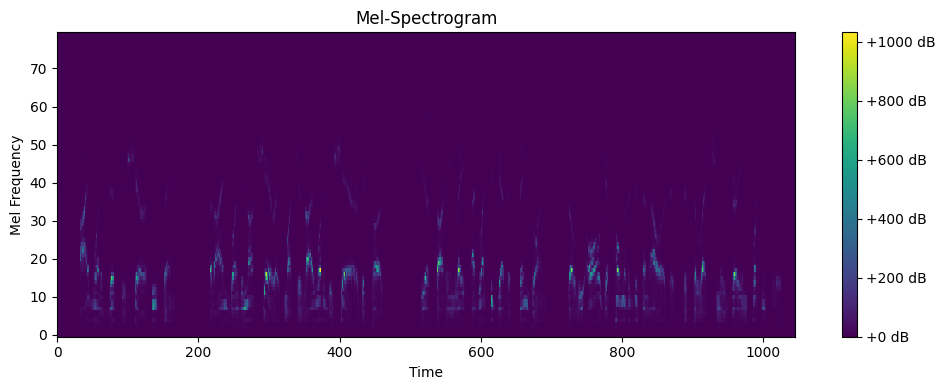

In [29]:
import torchaudio.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Example text-to-sequence preprocessing
def text_to_sequence(text, text_processor):
    return text_processor(text)

# Example audio-to-Mel-spectrogram preprocessing
def audio_to_mel_spectrogram(audio, sample_rate):
    transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=80)
    return transform(audio)

# Generate Mel-spectrogram
mel_spectrogram = audio_to_mel_spectrogram(output, 16000)

# Convert to NumPy for plotting
mel_spectrogram_np = mel_spectrogram.squeeze().detach().cpu().numpy()

# Plotting the Mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_np, aspect='auto', origin='lower', interpolation='none')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.tight_layout()